In [5]:
import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms

from dataset_utils import create_dataset
from pytorch_msssim import ssim
from models import load_model

from utils import threshold, criterion

device="cuda:0"
modality="vision"
model = load_model("imagebind", device)
batch_size = 1
seed=0
image_text_dataset = create_dataset("imagenet", model=model, device=device, embs_input="outputs/embeddings/imagenet_imagebind_embeddings.npy")
dataloader = DataLoader(image_text_dataset, batch_size=batch_size, shuffle=True)

IMG_MEAN=(0.48145466, 0.4578275, 0.40821073)
IMG_STD=(0.26862954, 0.26130258, 0.27577711)

def unnorm(tensor, mean=IMG_MEAN, std=IMG_STD):
    m = torch.tensor(IMG_MEAN)[None, :, None, None].to(device)
    s = torch.tensor(IMG_STD)[None, :, None, None].to(device)
    return (tensor.clone().to(device) * s) + m

def norm(tensor, mean=IMG_MEAN, std=IMG_STD):
    m = torch.tensor(IMG_MEAN)[None, :, None, None].to(device)
    s = torch.tensor(IMG_STD)[None, :, None, None].to(device)
    return (tensor.clone().to(device) - m) / s

transform = transforms.ToPILImage()

In [7]:
def semantic_perturbation(img1_tensor, img2_tensor, epsilon, epochs):
    img1_tensor=unnorm(img1_tensor.data)
    img2_tensor=unnorm(img2_tensor.data)

    img1_tensor_max = torch.clamp(img1_tensor+epsilon, min=0, max=1)
    img1_tensor_min = torch.clamp(img1_tensor-epsilon, min=0, max=1)

    img1_tensor_orig = img1_tensor.clone().detach()
    img1_tensor = img1_tensor.clone().detach().requires_grad_(True)

    optimizer = torch.optim.Adam([img1_tensor], lr=0.1)

    for i in range(epochs):
        optimizer.zero_grad()

        # Compute SSIM loss
        loss = 1 - ssim(img2_tensor, img1_tensor, data_range=1, size_average=True)

        loss.backward()
        
        # FGSM perturbation
        optimizer.step()    
        
        # Clip values to be in valid range [0, 1] and ensure perturbations are bounded by epsilon
        img1_tensor.data = torch.clamp(img1_tensor.data, img1_tensor_min, img1_tensor_max)

        if i % int(epochs/5) == 0:
            max_difference=torch.abs(img1_tensor_orig-img1_tensor).max().item()
            print(f"Iteration {i}, SSIM: {1 - loss.item()}"+", max difference: "+str(max_difference))

    return norm(img1_tensor), 1 - loss.item()

def adversarial_perturbation(X, Y, y_id, epsilon=0.05, epochs=100):
    succeess=False
    pbar = tqdm(range(epochs))
    X_init = X.clone().detach().cpu().requires_grad_(False)
    X, Y, y_id = X.to(device).requires_grad_(True), Y.to(device), y_id.to(device)
    
    X_max, X_min = threshold(X, epsilon, modality, device)

    lr=epsilon/epochs*10
    
    for i in pbar:
        
        embeds = model.forward(X, modality, normalize=False)
        loss = 1 - criterion(embeds, Y, dim=1)
        
        update = lr * torch.autograd.grad(outputs=loss.mean(), inputs=X)[0].sign()
        X = (X.detach().cpu() - update.detach().cpu()).to(device)
        X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
        max_difference=torch.abs(unnorm(X)-unnorm(X_init)).max().item()
        pbar.set_postfix({'loss': loss.detach().cpu(), 'eps': epsilon,'difference':max_difference,'success':succeess})

        if i % 10 == 0:
            classes = criterion(embeds[:, None, :], image_text_dataset.labels[None, :, :], dim=2).argsort(dim=1, descending=True)
            if torch.all((classes == y_id[:, None]).nonzero(as_tuple=True)[1].cpu() == 0):
                succeess=True
                # break   
        if max_difference>=epsilon and succeess==True:
            break
    return X

0


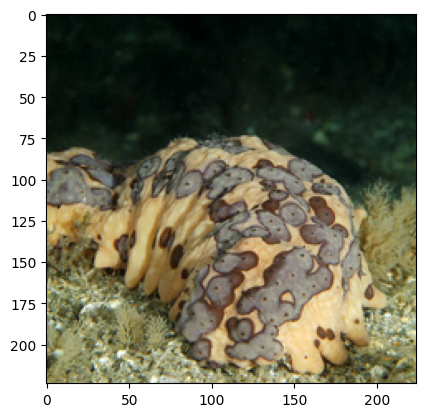

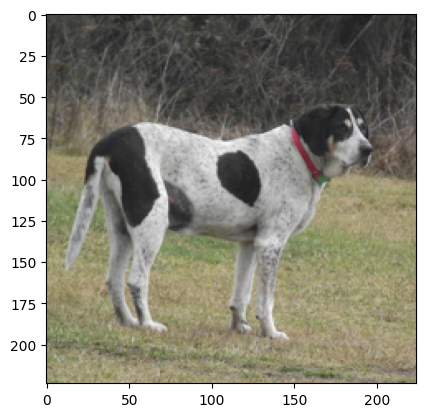

1


In [9]:
transform = transforms.ToPILImage()
torch.manual_seed(1208)
for i, (X, Y, gt, y_id, orig_label) in enumerate(dataloader):
    print(i)
    if i==1:
        break
    plt.imshow(transform(torch.squeeze(unnorm(X))))
    plt.show()
    plt.imshow(transform(torch.squeeze(unnorm(gt))))
    plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, SSIM: 0.13716447353363037, max difference: 0.010000020265579224
Iteration 40, SSIM: 0.20154047012329102, max difference: 0.010000020265579224
Iteration 80, SSIM: 0.2014906406402588, max difference: 0.010000020265579224
Iteration 120, SSIM: 0.20147883892059326, max difference: 0.010000020265579224
Iteration 160, SSIM: 0.20147669315338135, max difference: 0.010000020265579224


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, SSIM: 0.13716447353363037, max difference: 0.050000011920928955
Iteration 40, SSIM: 0.3950403332710266, max difference: 0.050000011920928955
Iteration 80, SSIM: 0.39535093307495117, max difference: 0.050000011920928955
Iteration 120, SSIM: 0.39530646800994873, max difference: 0.050000011920928955
Iteration 160, SSIM: 0.3952544927597046, max difference: 0.050000011920928955


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, SSIM: 0.13716447353363037, max difference: 0.09999805688858032
Iteration 40, SSIM: 0.5445030927658081, max difference: 0.10000002384185791
Iteration 80, SSIM: 0.5461305379867554, max difference: 0.10000002384185791
Iteration 120, SSIM: 0.5460941791534424, max difference: 0.10000002384185791
Iteration 160, SSIM: 0.5460211634635925, max difference: 0.10000002384185791


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, SSIM: 0.13716447353363037, max difference: 0.09999805688858032
Iteration 40, SSIM: 0.8264653086662292, max difference: 0.30000004172325134
Iteration 80, SSIM: 0.8342238664627075, max difference: 0.30000004172325134
Iteration 120, SSIM: 0.8341326713562012, max difference: 0.30000004172325134
Iteration 160, SSIM: 0.833889901638031, max difference: 0.30000004172325134


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, SSIM: 0.13716447353363037, max difference: 0.09999805688858032
Iteration 40, SSIM: 0.9418172836303711, max difference: 0.5
Iteration 80, SSIM: 0.9531553983688354, max difference: 0.5
Iteration 120, SSIM: 0.9530655741691589, max difference: 0.5
Iteration 160, SSIM: 0.9527891874313354, max difference: 0.5


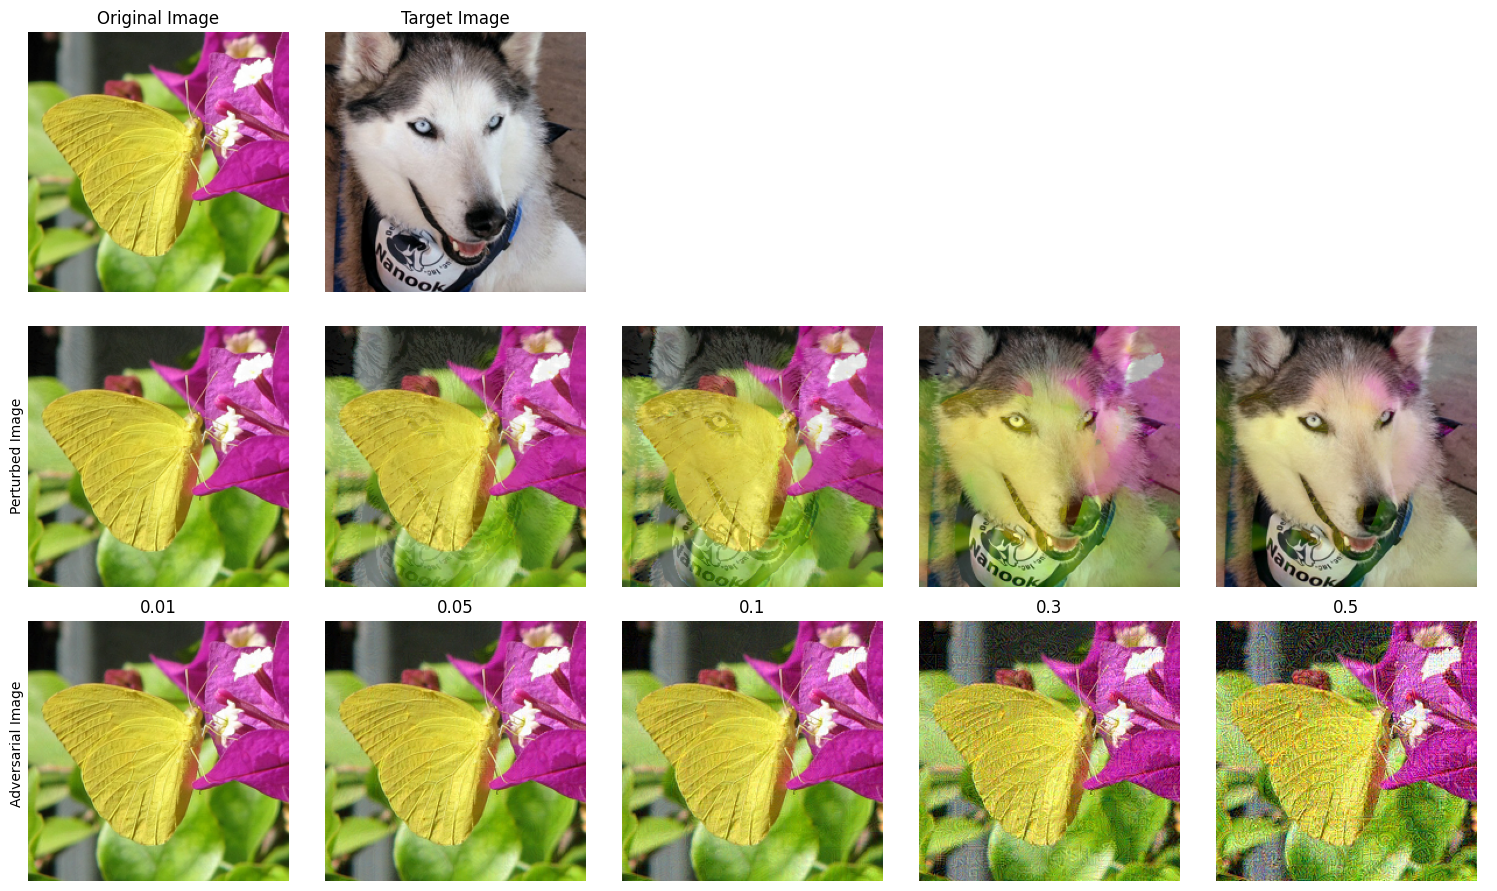

In [9]:
criterion = F.cosine_similarity
torch.manual_seed(1208)
eps=[0.01,0.05,0.1,0.3,0.5]

for i, (X, Y, gt, y_id, orig_label) in enumerate(dataloader):
    if i<19:
        continue
    if i>19:
        break
    X_advs=[]
    X_pers=[]
    for e in eps:
        X_adv=adversarial_perturbation(X, Y, y_id, epsilon=e, epochs=100)
        X_per, ss = adversarial_perturbation(X, gt, epsilon=e, epochs=200)
        X_advs.append(X_adv)
        X_pers.append(X_per)

    original_image = X
    target_image = gt
    perturbed_images = X_pers
    adversarial_images = X_advs
    
    # Create subplots
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    # First row: original and target images
    axes[0, 0].imshow(transform(unnorm(original_image).squeeze(0)))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    axes[0, 1].imshow(transform(unnorm(target_image).squeeze(0)))
    axes[0, 1].set_title('Target Image')
    axes[0, 1].axis('off')
    
    # Hide the other plots in the first row
    for ax in axes[0, 2:]:
        ax.axis('off')
    
    # Second row: perturbed images
    for i, (ax, img) in enumerate(zip(axes[1], perturbed_images)):
        ax.imshow(transform(unnorm(img).squeeze(0)))
        ax.axis('off')
    
    # Third row: adversarial images
    for i, (ax, img) in enumerate(zip(axes[2], adversarial_images)):
        ax.imshow(transform(unnorm(img).squeeze(0)))
        ax.set_title(f'{eps[i]}')
        ax.axis('off')
    
    # Add notations using fig.text
    x_position = 0.01  # Adjust as needed to position the text
    y_positions = [0.49, 0.17]  # Rough estimates, adjust as needed
    fig.text(x_position, y_positions[0], "Perturbed Image", va='center', ha='center', rotation='vertical')
    fig.text(x_position, y_positions[1], "Adversarial Image", va='center', ha='center', rotation='vertical')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    break

In [10]:
from torchvision.utils import save_image
input_dir="certified_images/"
for i, img in enumerate(perturbed_images):
    save_image(torch.squeeze(unnorm(img)), os.path.join(input_dir, f'perturbed_images_{i}.png'))

for i, img in enumerate(adversarial_images):
    save_image(torch.squeeze(unnorm(img)), os.path.join(input_dir, f'adversarial_image_{i}.png'))

save_image(torch.squeeze(unnorm(original_image)), os.path.join(input_dir, f'original_image.png'))
save_image(torch.squeeze(unnorm(target_image)), os.path.join(input_dir, f'target_image.png'))